In [4]:
import os
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

imgFile = "/Large_Scaled_Forest_Lizard.jpg"
imgBGR = cv2.imread(imgFile)

cv2_imshow(imgBGR)

Output hidden; open in https://colab.research.google.com to view.

In partea de sus am facut niste importuri si am deschis si afisat imaginea cu open CV

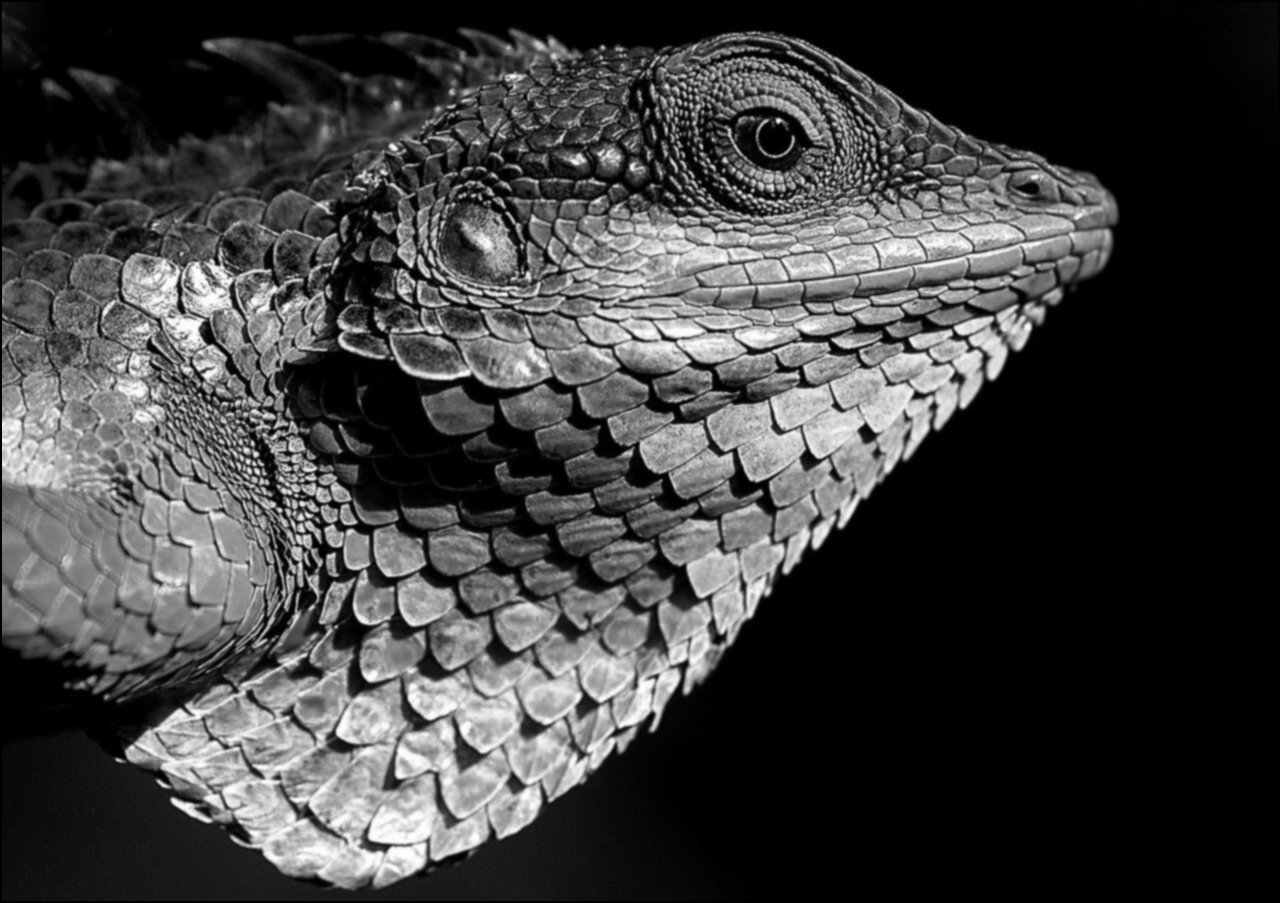

In [10]:
#imgGray = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
#imgGaussianBlur = apply_gaussian_blur(imgGray,(5,5),1.4)
#cv2_imshow(imgGaussianBlur)

imgGray = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )

    return kernel / np.sum(kernel)

def apply_gaussian_blur(image, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)

    # Dimensiunile imaginii
    height, width = image.shape

    # Inițializați o imagine goală pentru imaginea filtrată
    blurred_image = np.zeros((height, width), dtype=np.uint8)

    # Aplică filtrul Gaussian manual
    for x in range(2, height - 2):
        for y in range(2, width - 2):
            neighborhood = image[x - 2 : x + 3, y - 2 : y + 3]  # Dimensiunea vecinătății este 5x5
            filtered_pixel = np.sum(neighborhood * kernel)
            blurred_image[x, y] = int(filtered_pixel)

    return blurred_image

# Aplică filtrul Gaussian
imgGaussianBlur = apply_gaussian_blur(imgGray, kernel_size=5, sigma=1)

# Afișează imaginea
cv2_imshow(imgGaussianBlur)
cv2.waitKey(0)
cv2.destroyAllWindows()


Ca prim pas al procesarii am aplicat un gaussian blur cu un kernel de 5x5.

Caracteristica Gaussian Blur este obținută prin estomparea (netezirea) unei imagini folosind o funcție Gaussiană pentru a reduce nivelul de zgomot. Poate fi considerată ca un filtru trece-jos neuniform care reduce zgomotul imaginii și detalii neglijabile dintr-o imagine. De obicei, este realizată prin convoluția unei imagini cu un kernel Gaussian. Acest kernel Gaussian în forma sa 2-D este exprimat ca:

\begin{equation}
G_{2 D} x y \sigma=\frac{1}{2 \pi \sigma^2} e^{-\frac{x^2+y^2}{2 \sigma^2}}
\end{equation}

unde σ este deviația standard a distribuției, iar x și y sunt indicii de locație. Valoarea lui σ controlează varianța în jurul unei valori medii a distribuției gaussiene, care determină extinderea efectului de estompare în jurul unui pixel.

Dupa am aplicat filtrul gausian folosind un kernel_size = 5 si σ = 1

(Text(0.5, 1.0, 'Sobel Angle'), ([], []), ([], []))

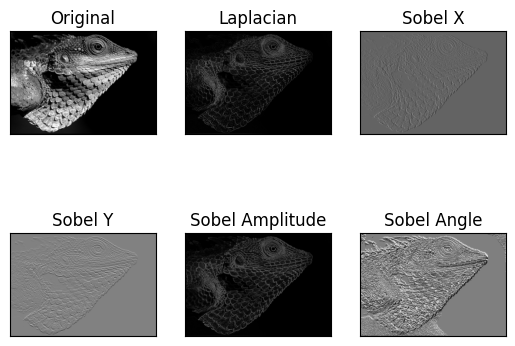

In [7]:
laplacian = cv2.Laplacian(imgGaussianBlur, -1, ksize=3, scale=1, delta=0 ,borderType=cv2.BORDER_DEFAULT)
sobelx = cv2.Sobel(imgGaussianBlur,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(imgGaussianBlur,cv2.CV_64F,0,1,ksize=3)
combinedSobelAmplitude = cv2.sqrt( sobelx * sobelx + sobely * sobely)
combinedSobelPhase = np.arctan2(sobely, sobelx)

plt.subplot(2,3,1),plt.imshow(imgGaussianBlur, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(combinedSobelAmplitude,cmap = 'gray')
plt.title('Sobel Amplitude'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,6),plt.imshow(combinedSobelPhase,cmap = 'gray')
plt.title('Sobel Angle'), plt.xticks([]), plt.yticks([])

In continuare am aplicat operatorii Sobel si Laplacian. Acestia sunt operatori ce implementeaza detectia de gradient.

Aplicarea acestori operatori este o convolutie cu un o matrice pre stabilita. In urma careia rezulta o "imagine" cu informatie legata de directia si intensitatea gradientului prezent intre nivele de gri la fiecare punct din imagine.

In cazul operatorului Sobel sunt folosite 2 matrici, fiecare menita sa detecteze schimbari de gradient pe o alta axa, una pe orizontala si una pe verticala. Matricile Sobel arata asa:

$Gx = \begin{pmatrix}
  1 & 0 & -1
  2 & 0 & -2 \\
  1 & 0 & -1
 \end{pmatrix}$
 $Gy = \begin{pmatrix}
  1 & 2 & 1 \\
  0 & 0 & 0 \\
  -1 & -2 & -1
 \end{pmatrix}$

 In cazul functiei Laplacian aceasta foloseste o alta matrice kernel. Principiul ei de functionare este putin diferit dar rezultatul este similar. In loc sa calculeze gradientul imagini ea calculeaza cat se schimba imaginea la fiecare punct, ii putem spune "derivata" imagini. Kernelul folosit in acest context este:

 $L = \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0
 \end{pmatrix}$

 In plus pentru a calcula rezultatul final al operatorului Sobel trebuie sa calculez amplitudinea si faza gradientelor.

\begin{align}
        G = \sqrt{Gx^2 + Gy^2} \\
        Θ = atan2(Gy, Gx)
\end{align}



In [ ]:
def maximum(det, phase):
  gmax = np.zeros(det.shape)
  for i in range(gmax.shape[0]):
    for j in range(gmax.shape[1]):
      if phase[i][j] < 0:
        phase[i][j] += 360

      if ((j+1) < gmax.shape[1]) and ((j-1) >= 0) and ((i+1) < gmax.shape[0]) and ((i-1) >= 0):
        # 0 degrees
        if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
          if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
            gmax[i][j] = det[i][j]
        # 45 degrees
        if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
          if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
            gmax[i][j] = det[i][j]
        # 90 degrees
        if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
          if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
            gmax[i][j] = det[i][j]
        # 135 degrees
        if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
          if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
            gmax[i][j] = det[i][j]
  return gmax

def threshold(img, lowThresholdRatio=0.1, highThresholdRatio=0.3):

  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;

  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)

  weak = np.int32(25)
  strong = np.int32(255)

  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)

  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak

  return res

Mai sus avem functia care suprima elementele non maxime ale imaginii. Ea este gandita pentru a fi folosita cu rezultatul Sobel operatorului asa ca are ca input amplitudinea si unghiul gradientelor.
In aceasta functie verific 2 pixeli adiacenti la unghi de 0/45/90/135 de grade si daca exista pe acel unghi un gradient in directia de masura atunci el va fi suprimat

In Plus avem functia de threshold, ea parcurge imaginea si clasifica pixelii 3 categorii
1. Pixeli puternici, pixeli de o intensitate foarte mare care garantat fac parte dintr-o margine, peste treshold-ul maxim
2. Pixeli slabi, pixeli de o intensitate mai mica ce nu este inca stabilit, intre cele 2 threshold-uri
3. Pixeli irelevanti, pixeli ce se afla sub valoarea de treshold minima si sunt lasati in 0

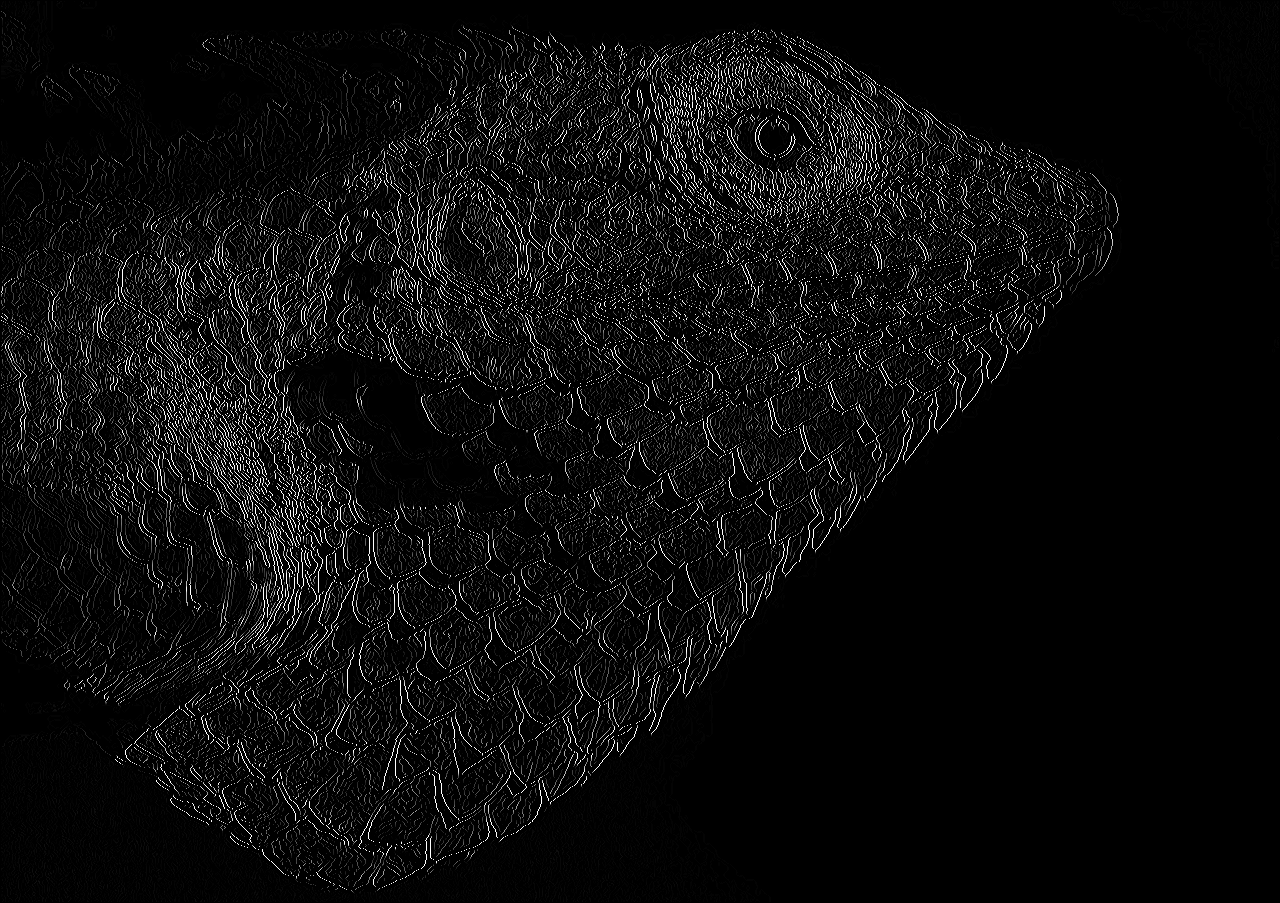

In [ ]:
suppressed = maximum(combinedSobelAmplitude, combinedSobelPhase)
thresholdImage = threshold(suppressed)

cv2_imshow(suppressed)

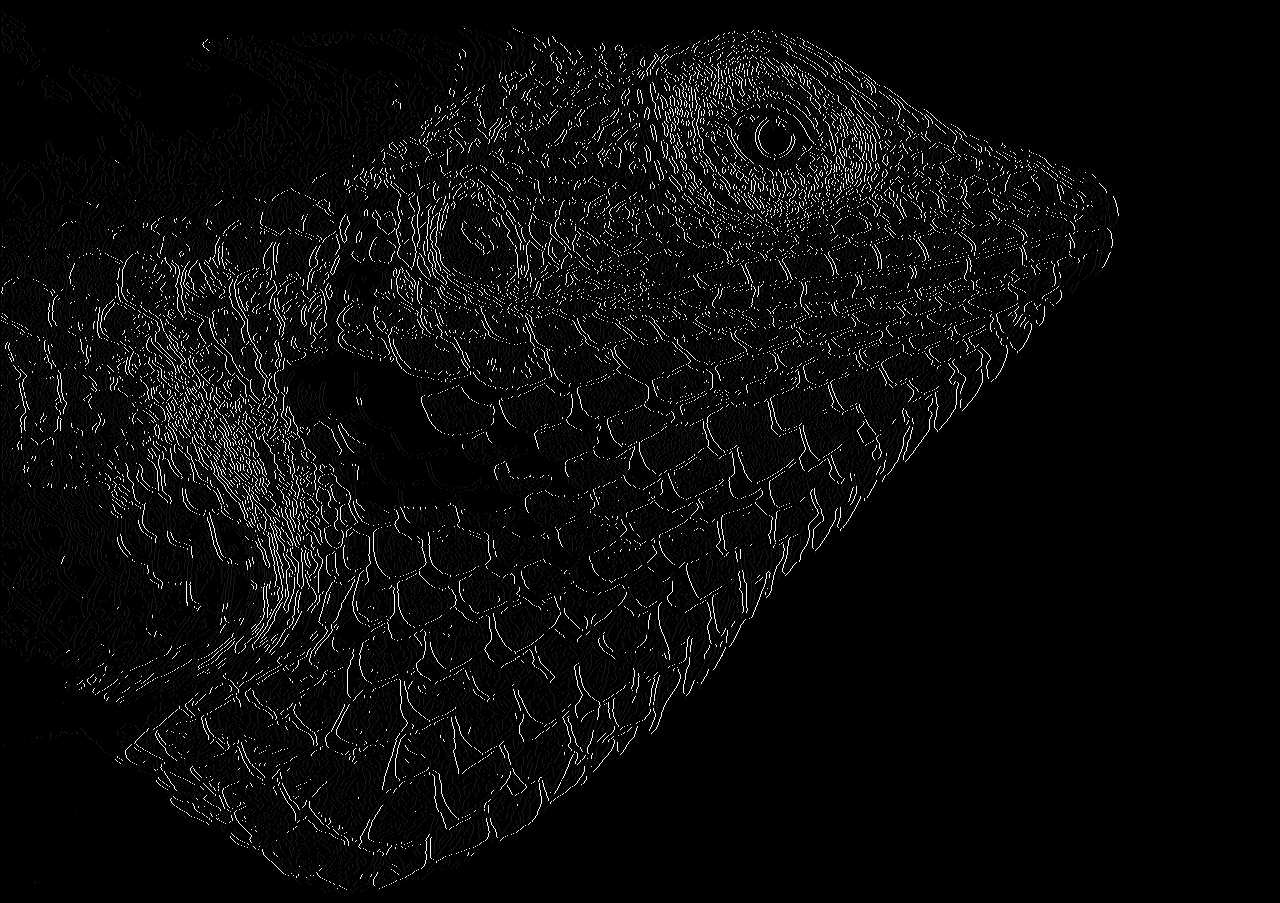

In [ ]:
cv2_imshow(thresholdImage)

In acest pas putem vedea rezultatele celor 2 operatii

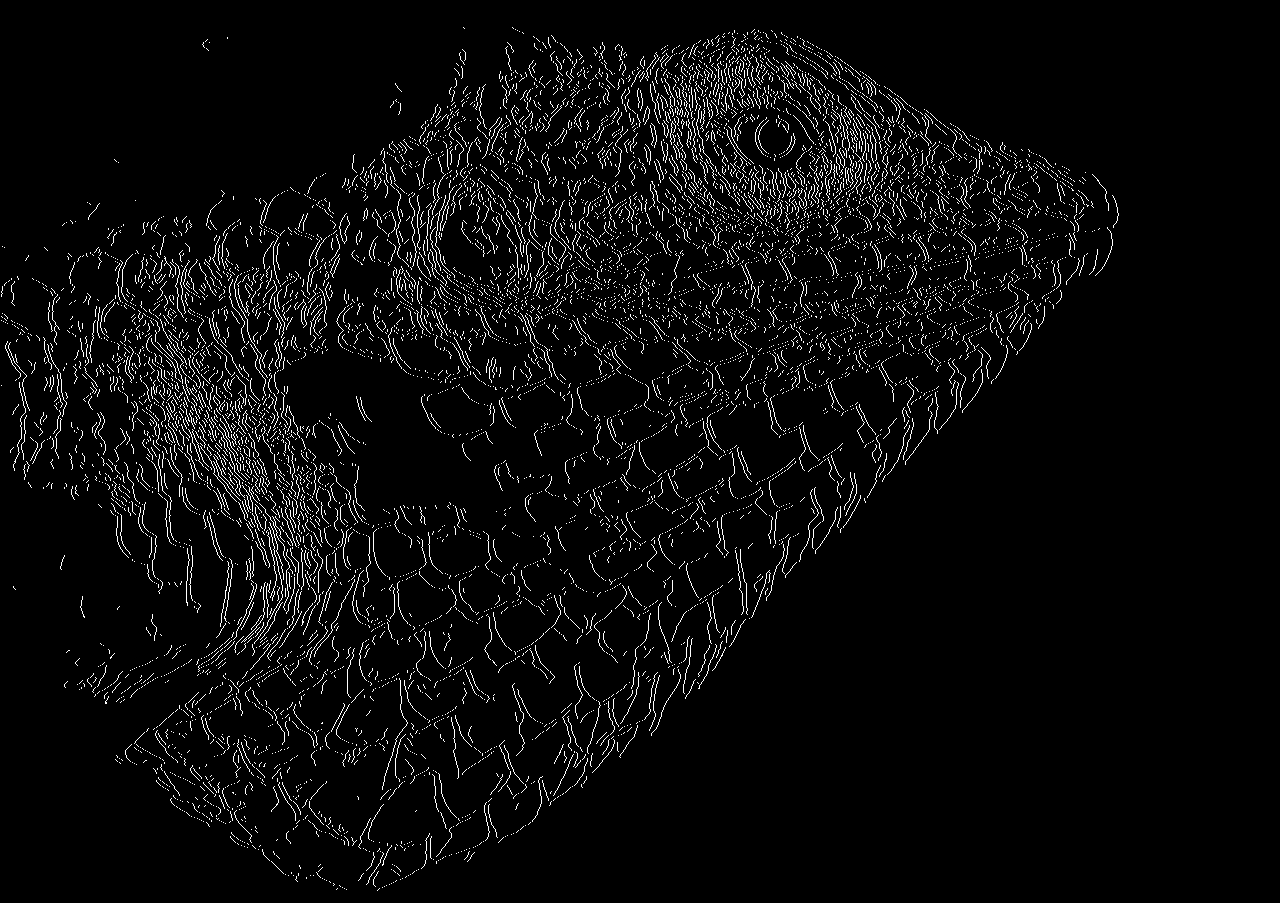

In [ ]:
def hysteresis(img, weak=25, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

edgeDetected = hysteresis(thresholdImage)
cv2_imshow(edgeDetected)